<br><br>

<div style='text-align: center;'> <h2>Recurrent Neural Network for Twitter Sentiment Analysis</h2>

</div>
<br> 

&emsp;&emsp;&emsp;&emsp;**This project involves the implementation and employment of a recurrent neural network with embedding and advanced attentional mechanisms for sentiment analysis, particularly training on and analyzing tweets. Sentiment analysis, as implied by the term, involves analyzing the content of a given text to determine the emotional undertone or sentiment most appropriate to it. This practice is particularly helpful for a variety of purposes, chief among them is understanding and learning from public perception and public opinion, whether to understand the public stance towards a particular topic, company, or service; for research and development; to better manage and monitor social spaces (for instance by uprooting hateful, inciting or inflammatory content); or even to better understand the general social and political climate, which has a direct bearing on the stocks and forex markets and can thus inform decisions related thereto. Indeed, with the unrelenting increased digitization of the public sphere, sentiment analysis, especially as applied to large-scale social media platforms like X/twitter, has become pivotal for companies everywhere to better manage the public reception of their products and services and to ensure their betterment and meet customers' expectations aptly, thus greatly aiding companies' pursuit of growth and quality. To that end, I endeavoured to develop a recurrent neural network with various attentional and optimization mechanisms and train it on a large dataset of tweets to learn to distinguish between different sentiment and identify the correct sentiment for each individual tweet.**


<br>

&emsp;&emsp;&emsp;&emsp;**The dataset presented here was taken from Kaggle, which you can quickly access from the following [link](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset/). This dataset is comprised of approximately 27,500 tweets, each tweet labelled in advance with the sentiment appropriate to it. Sentiment labels present are simply "positive", "negative", or "neutral". Each row in the data includes the tweet's text content and a corresponding sentiment label. The goal here, as mentioned, is to develop a neural network that learns from this dataset to correctly identify the sentiment or emotion that perfectly fits a given post.**<br> 
<br>

**You can view each column and its description in the table below:** <br><br>  

| **Variable**      | **Description**                                                                                         |
| :-----------------| :------------------------------------------------------------------------------------------------------ |
| **textID**       | Unique identifier for each tweet                                                             |
| **text**| Raw text of the tweet                                                     |
| **selected_text**    | Most relevant or informative part of the tweet for deciding sentiment                                                                                       |
| **sentiment**  | Sentiment label corresponding to the tweet (neutral, positive, or negative)              |

<br>
<br>



&emsp;&emsp;&emsp;&emsp;**Prior to model development, the dataset was quickly inspected and cleaned before being thoroughly preprocessed and prepared for training. Preparatory steps included removing hyperlinks, hashtags, stop words, emojis and emoticons, and lemmatization. The tweets were then tokenized and padded to be fed appropriately to the model. A recurrent neural network was then developed and trained for sentiment analysis. It was also endowed with several attentional capabilities to facilitate sentiment analysis. As such, this network roughly consisted of the following: an embedding layer for word embedding; a mask layer, which specialized in masking sentiment or emotional words, adding more emphasis to them during training; a bidirectional Long-Short Term Memory (LSTM) layer to learn context and semantic dependencies in the data; a self-attention for added importance on the most relevant parts of the text; and finally a dense layer with 3 units for classification. Each layer fedforward to the next one before terminating at the classification layer to identify the sentiment appropriate to a given tweet. Finally, the network was then tested on a separate testing set for a final evaluation. The network yielded considerably favorable results.** <br>

<br>

**Overall, the project is comprised of 3 sections: <br>
&emsp; 1) [Reading and Inspecting the Data](#reading-and-inspecting-the-data) <br>
&emsp; 2) [Data Preparation and Preprocessing](#data-preparation-and-preprocessing) <br> 
&emsp; 3) [Model Development and Evaluation](#model-development-and-evaluation)** <br>

<br>
<br>


**Install Required Modules**

In [ ]:
!pip install numpy pandas matplotlib seaborn nltk scikit-learn tensorflow --quiet

**Importing Python Modules**

In [ ]:
#import necessary modules
import os
import re 
import math 
import random
import string
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf   
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import layers, optimizers, regularizers        
from tensorflow.keras.callbacks import EarlyStopping, Callback    
from tensorflow.keras.preprocessing.text import Tokenizer      
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#Adjust pandas data display settings 
pd.set_option('display.max_colwidth', 100)

#Set plotting context and style
sns.set_context('notebook')
sns.set_style('white')
%matplotlib inline

**Random Seed**

In [ ]:
#Set random seed for reproducible results
rs = 121

#set global random seed to libraries used 
random.seed(rs)
np.random.seed(rs)
tf.random.set_seed(rs)


**Defining Helper Functions for data analysis and visualization**

In [3]:
#Defining a function to compute and report error scores
def error_scores(ytest, ypred, model_accuracy, classes):
    error_metrics = {
        'Accuracy': model_accuracy,
        'Precision': precision_score(ytest, ypred, average=None),
        'Recall': recall_score(ytest, ypred, average=None),
        'F1 score': f1_score(ytest, ypred, average=None),
    }

    return pd.DataFrame(error_metrics, index=classes).apply(lambda x:round(x,2)).T


#Define function to plot the confusion matrix using a heatmap
def plot_cm(cm, labels):
    plt.figure(figsize=(10,7))
    hmap = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
    hmap.set_xlabel('Predicted Value', fontsize=13)
    hmap.set_ylabel('Truth Value', fontsize=13)
    plt.tight_layout()


#Define custom function to visualize model training history
def plot_training_history(run_histories: list, metrics: list = None, title='Model run history'):
    #If no specific metrics are given, infer them from the first history object
    if not metrics:
        metrics = [key for key in run_histories[0].history.keys() if 'val_' not in key]
    else:
        metrics = [metric.lower() for metric in metrics]

    #Set up the number of rows and columns for the subplots
    n_metrics = len(metrics)
    n_cols = min(3, n_metrics)  #Limit to a max of 3 columns for better readability
    n_rows = math.ceil(n_metrics / n_cols)

    #Set up colors to use
    colors = ['steelblue', 'red', 'skyblue', 'orange', 'indigo', 'green', 'DarkCyan', 'olive', 'brown', 'hotpink']

    #Ensure loss first is plotted first
    if 'loss' in metrics:
        metrics.remove('loss')
        metrics.insert(0,'loss')

    #Initialize the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5*n_cols, 5 * n_rows))
    axes = axes.flatten() if n_metrics > 1 else [axes]

    #Loop over each metric and create separate subplots
    for i, metric in enumerate(metrics):
        #Initialize starting epoch
        epoch_start = 0
        for j, history in enumerate(run_histories):
            epochs_range = range(epoch_start, epoch_start + len(history.epoch))

            #Plot training and validation metrics for each run history
            axes[i].plot(epochs_range, history.history[metric], color=colors[i*2], ls='-', lw=2, label=(f'Training {metric}') if j==0 else None)
           # axes[i].set_xticks(epochs_range)
            if f'val_{metric}' in history.history:
                axes[i].plot(epochs_range, history.history.get(f'val_{metric}', []), color=colors[i*2+1], ls='-', lw=2, label=(f'Validation {metric}') if j==0 else None)

            #Update the epoch start for the next run
            epoch_start += len(history.epoch)

        #Set the titles, labels, and legends
        axes[i].set(title=f'{metric.capitalize()} over Epochs', xlabel='Epoch', ylabel=metric.capitalize())
        axes[i].legend(loc='best')

    #Remove any extra subplots if the grid is larger than the number of metrics
    for k in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[k])

    fig.suptitle(title, fontsize=16, y=(0.95) if n_rows>1 else 0.98)
    plt.show()

#Define custom function decode tokens, returning them to raw text
def decode_tokens(indexed_tokens, idx2word_dict):
  return ' '.join([idx2word_dict[index] for index in indexed_tokens if index!=0])


<a id="reading-and-inspecting-the-data"></a> 
## Part One: Reading and Inspecting the Data


**Loading and reading the dataset**

In [4]:
#Access and read data into dataframe
df = pd.read_csv('Tweets.csv')

#Report total count 
print(f'Total number of tweets: {df.shape[0]:,}')


Total number of tweets: 27,481


#### Inspecting the data

**Previewing the data**

In [5]:
#Show a random sample of 10 tweets
df.sample(10)


,textID,text,selected_text,sentiment
25212,e145f04c31,D= indeed,D= indeed,neutral
19875,2c993b420a,"they are terrible little beast but if the garden is small you can simply collect them, or you c...",e terrible,negative
17826,dbc02fbb6f,I really wish i would hear from josh,I really wish i would hear from josh,neutral
9905,8c32aab25f,You Got Twitter! Yayy ****,Yayy,positive
19773,669237d42b,installed the iNav iBlue v2 Theme...gives a fresh feel http://twitpic.com/4jfg4,fresh,positive
21691,6bd9ddc994,_B if you`re in leeds you can have one from me,_B if you`re in leeds you can have one from me,neutral
20649,19cc8138fd,One more thing 'Shattered' is an amazing song by O.A.R.,amazing,positive
11057,f973d336f8,hiya! did you get a picture of your converse?? GET YOUR CONVERSE OUT!,hiya! did you get a picture of your converse?? GET YOUR CONVERSE OUT!,neutral
15424,42e9dce94a,Happy Mama`s day to all mothers,Happy,positive
9947,23fe4acb90,Will try to make it there at 6:30pm,Will try to make it there at 6:30pm,neutral


**Checking number of entries and data type per column**

In [6]:
#Inspect columns, data types, number of non-null entries
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


**Descriptive Statistics**

In [7]:
#get statistical overview 
df.describe().T

,count,unique,top,freq
textID,27481,27481,cb774db0d1,1
text,27480,27480,"I`d have responded, if I were going",1
selected_text,27480,22463,good,199
sentiment,27481,3,neutral,11118


**Drop empty rows**

In [8]:
#Drop null entries 
df = df.dropna(ignore_index=True)

#report number of empty rows after dropping 
print('Number of empty rows:', df.isnull().sum().sum())


Number of empty rows: 0


Now having gleaned a general overview of the data, we can proceed to part two: preparing and preprocessing the data to make it ready for model development and training.

<br>

<a id="data-preparation-and-preprocessing"></a>
## Part Two: Data Preparation and Preprocessing
In this section, I will start preparing the data and performing text preprocessing on the tweets column in anticipation of modelling the data. First, I will start with the target variable, sentiment, performing label encoding to give numeric labels to the sentiment classes and make them viable for analysis. Then, I will turn to the text data (tweets), performing text preprocessing to cut through the clutter and filter the text to its most informative elements. This process will consist of the following:

1. Lowercasing and removing whitespaces 
2. Removing hyperlinks 
3. Removing mentions and hashtags 
4. Removing punctuations 
5. Removing stop words 
6. Lemmatizing the text, particularly nouns, reducing each to its dictionary root. 
7. Removing emojis, emoticons, and symbols. 
8. Text tokenization, converting text sequences to numeric sequences, whereby words are represented as unique numeric tokens.
9. Sequence padding, ensuring all sequences are of the same size. 
<br>

This should help make the analysis concise and focused on what's most relevant in the text and thus facilitate sentiment analysis and classification. Finally, having preprocessed the text thoroughly, I will identify the predictor and target variables and perform data splitting. I shall start with label encoding.
<br><br>

**Label Encoding** <br>

For label encoding, I will assign 0 to neutral, 1 to positive sentiments, and 2 to negative ones.

In [9]:
#Perform label encoding on the target class
classes = {'neutral': 0, 'positive': 1, 'negative': 2}

#Replace string labels with numeric labels
df['sentiment'] = df['sentiment'].replace(classes)


**Class Distribution**

Class Distribution (in %):

sentiment
0    40.45%
1    31.23%
2    28.32%
Name: proportion, dtype: object 




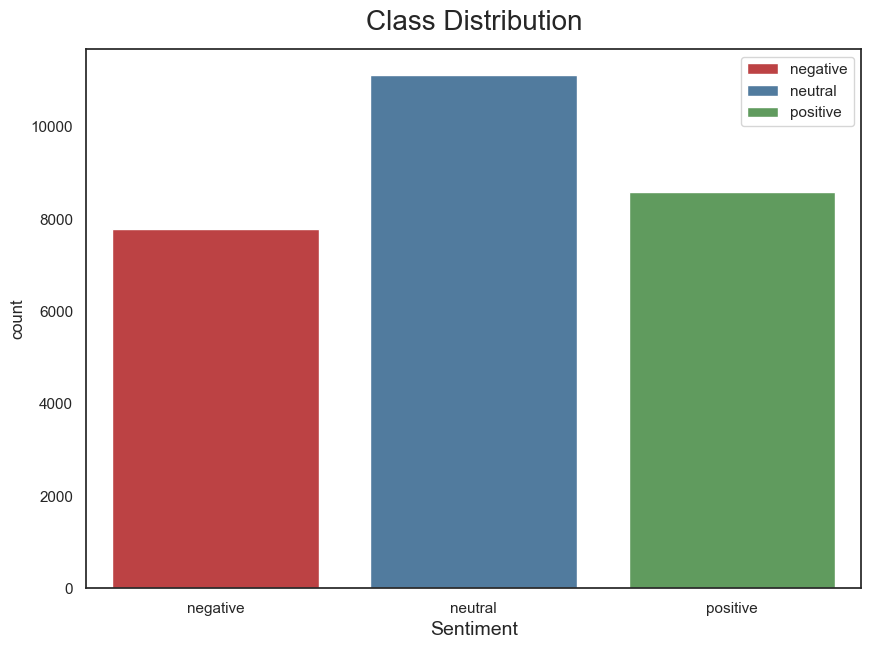

In [10]:
#Examine Class Distribution 
print('Class Distribution (in %):\n')
print(df['sentiment'].value_counts(normalize=True).apply(lambda x: f'{x*100:.2f}%'),'\n\n')

#Visualizing the class distribution using count plot
plt.figure(figsize=(10,7))
ax = sns.countplot(x=df['sentiment'], hue=df['sentiment'], order=[2,0,1], hue_order=[2,0,1], saturation=.6, palette='Set1')
ax.set_title('Class Distribution', fontsize=20, pad=14)
ax.set_xlabel('Sentiment', fontsize=14)
ax.set_xticklabels(['negative', 'neutral', 'positive'])
ax.legend(labels=['negative', 'neutral', 'positive'])
plt.show()


### Text Preprocessing

Now I will proceed to deal with the text data in particular. To facilitate the process, I will create a custom function that handles most of the text processing steps in one go and apply it on the dataset. This function, `preprocess_text`, should normalize the text, remove hyperlinks, mentions, hashtags, punctuations, and stopwords, and lastly lemmatize the text. I will also create a second function, `remove_emojis`, that will identify and remove all emojis, emoticons and symbols from the data. This should output a completely clean version of the text. Finally, I will perform text tokenization and padding.

In [11]:
#Instantiate nltk's lemmatizer and stop words' list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


#Preprocessing function
def preprocess_text(text):
    text = text.lower().strip()  #lowercase and remove whitespaces
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  #remove URLs 
    text = re.sub(r'@\w+|#\w+', '', text)  #remove mentions and hashtags
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  #remove punctuations
    text = text.split()   #split string to list
    text = [word for word in text if word not in stop_words]  #remove stop words 
    text = [lemmatizer.lemmatize(word) for word in text]   #lemmatize text (nouns)
    return ' '.join(text)

#Define a function to remove emojis and emoticons from text
def remove_emojis(text):
    #Regex pattern to match emojis and emoticons
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  #emoticons
        u"\U0001F300-\U0001F5FF"  #symbols & pictographs
        u"\U0001F680-\U0001F6FF"  #transport & map symbols
        u"\U0001F700-\U0001F77F"  #alchemical symbols
        u"\U0001F1E0-\U0001F1FF"  #flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)  #remove emojis


#Preprocess all tweets and save into new column
df['text_preprocessed'] = df['text'].apply(preprocess_text).replace('', np.nan)

#Drop empty rows
df = df.dropna(ignore_index=True)

#Apply second function to remove all symbols and emojis 
df['text_preprocessed'] = df['text_preprocessed'].apply(remove_emojis)


#preview a sample after preprocessing
print('Sample of preprocessed text:\n')
df['text_preprocessed'].sample(5)


Sample of preprocessed text:



21759                                                    want new moon ahh im going crazy
5950     wow god whole ui sooo much snappier responsive tweetdeck tweet feel like ims lol
6753                                                                      public bathroom
16155                                                  lunch w jason deli stepped dog poo
21194                  say impossible plurk work system administrator closed access firew
Name: text_preprocessed, dtype: object

**Text tokenization**

In [12]:
#Instantiate tokenizer 
tokenizer = Tokenizer()

#tokenize text corpus 
tokenizer.fit_on_texts(df['text_preprocessed'])

#convert the text into sequences of word indice
df['text_preprocessed'] = tokenizer.texts_to_sequences(df['text_preprocessed'])

#get token indices and report vocabulary size
word2idx = tokenizer.word_index
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx) + 1
print('vocabulary size:', vocab_size)


vocabulary size: 25541


**Sequence padding**

In [13]:
#Get maximum sequence length
max_seq_len = max([len(seq) for seq in df['text_preprocessed']])

#apply padding
df['text_preprocessed'] = list(pad_sequences(df['text_preprocessed'], padding='post', maxlen=max_seq_len))

#Preview data sample
df.sample(5)


,textID,text,selected_text,sentiment,text_preprocessed
10360,f0b7a05584,"Thanks for the heads up, Ethan. Watching it now",Thanks,1,"[34, 198, 6438, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
12944,50356857dc,Is sooo waking both of them up on my way back to SB good night america,Is sooo waking both of them up on my way back to SB good night america,1,"[315, 893, 68, 21, 3245, 3, 25, 1194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15160,8dd4fb2c3f,There are some great honey based recipes for you & the kids to download at - http://twurl.nl/l...,great ho,1,"[37, 1274, 2121, 1870, 201, 1049, 758, 48, 1274, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
14710,a907a8f7ee,"Wal-Mart orientation...it`s work, but seriously...this sucks","Wal-Mart orientation...it`s work, but seriously...this sucks",2,"[2251, 17957, 10, 17958, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
25436,4c0e5429a0,"haha, sorry, it`s past my bedtime","sorry,",2,"[43, 54, 527, 1548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


**Data Selection**

In [14]:
#Data Selection
#Identify predictor and target variables
X_data = df['text_preprocessed']
y_data = df['sentiment'].values


**Stratified Data Splitting**

In [16]:
#Obtain training, testing, and validation sets (70% training / 15% testing / 15% validation)
#first split 70/30
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, train_size=0.7, stratify=y_data, random_state=rs)

#second split 67/33
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp,  random_state=rs)

#Convert data to numpy arrays
X_train = tf.convert_to_tensor(X_train.tolist(), dtype=tf.int32)
X_val = tf.convert_to_tensor(X_val.tolist(), dtype=tf.int32)
X_test = tf.convert_to_tensor(X_test.tolist(), dtype=tf.int32)

#Check the sizes of the training, validation and testing sets
print(f'Number of training samples: {X_train.shape[0]:,}')    
print(f'Number of validation samples: {X_val.shape[0]:,}')    
print(f'Number of testing samples: {X_test.shape[0]:,}')


Number of training samples: 19,187
Number of validation samples: 5,509
Number of testing samples: 2,714


*Now data preprocessing is complete. I will now proceed to model development and training...*

<br>

<a id="model-development-and-evaluation"></a>
## Part Three: Model Development and Evaluation 

In this section, I will develop, train and evaluate a recurrent neural network for the present task of sentiment analysis. Well, first I will attempt to establish a baseline for performance by training a simple classification model, particularly a logistic regression model. Then, I will proceed to building the network to compare the results. This network should roughly consist of embedding layer, a sentiment mask layer for attention to sentimental or sentiment-adjascent terms, a bidirectional LSTM layer, a trainable self-attention layer, and finally a classification layer, as well as optimization and dropout layers in between (*see full architecture below*). What makes this network particularly special is the attentional capabilities built into it, making it particularly specialized for the task of sentiment analysis.  With that being said, I shall proceed with establishing a performance baseline for the network to come. 
<br>
<br>

**Establishing a Performance Baseline**

In [17]:
#Instantiate a logistic regression object
LR = LogisticRegression(max_iter=500, random_state=rs)

#fit the model
model = LR.fit(X_train, y_train)

#generate predictions
y_pred = model.predict(X_test)

#report error scores 
print('Logistic Regression classification results:')
error_scores(y_test, y_pred, accuracy_score(y_test, y_pred), classes=classes)


Logistic Regression classification results:


,neutral,positive,negative
Accuracy,0.40,0.40,0.40
Precision,0.41,0.38,0.30
Recall,0.95,0.04,0.02
F1 score,0.57,0.08,0.05


As seen for the results of the baseline logistic regression model, not much was gleaned from the data, with an overall accuracy score of 0.40. This is strikingly so for the positive and negative sentiments, with a modest precision scores and recall and F1 scores below 0.1 for both! Well, this should be expected for, indeed, these simple machine learning models are not particularly made for dealing with text data or natural language processing (NLP), unlike neural networks with specialized layers. Nonetheless, I will use this as a starting point, a baseline, against which I will compare the performance of the neural network to be built after training, which will give us a rough idea about how it fares relative to traditional machine learning models like this one. 

### Model Design and Architecture <br>

Now we turn to model development. In this part, I will elaborate on the design of the network and the preparatory steps required for building it. The chief purpose of this network is to learn the appropriate embeddings by modeling a large collection of tweets and their corresponding sentiment labels so that it's able to perform sentiment analysis and thus become capable of identifying the sentiments most appropriate to any given tweet, especially in the case of positive and negative sentiments. As such, overall it will perform word embeddings, focusing more heavily on sentiment embeddings; attend to local patterns and word combinations most predictive; learn context and semantic dependencies between words in a sentence; learn to attend to the most relevant/predictive details; and finally classify tweets based on what have been learned, labeling each tweet as either positive, negative, or neutral. To that end, this network will primarily cosist of the following layers:<br>
<div style="padding-left: 1em; max-width: 1350px;">
<p style="line-height: 1.5;">

**(1) Embedding layer:** a word embedding layer for transforming word tokens into (300-dimensional) dense vectors that represent semantic relationships in the input word sequences fed to it. This layer will utilize GloVe's pre-trained embedding weights for a start, but will remain trainable. <br>

**(2) Gaussian Noise layer:** this noise layer, enabled only during training, will introduce slight purtubations or noise into the learned word representations to help the model generalize better and reduce overfitting on the training data, forcing the network to rely on more stable and robust patterns. <br>

**(3) Sentiment Mask layer:** this masking layer will take in the embeddings from the earlier layer and the input word tokens and apply additional emphasis on sentiment terms, increasing their respective weights by a certain factor. To perform masking appropriately, I used a dictionary of sentimental or sentiment-laden terms (collected from EmoLex), and tokenized it using the same tokenizer for current text corpus to allow direct comparisons based on this particular dataset. <br>

**(4) Self-Attention layer:** a scaled dot-product attention layer with trainable weights to help selectively focus on the most relevant words relative to their sequences overall, even if far apart in time, assigning added weight to these terms deemed relevant or important for predicting sentiment. Such self-attention layers are particularly good for short and noisy data like tweets with a lot of slang and abrupt transitions. Further, placed after the sentiment mask layer, and before the convolutional layers, this layer would, on the one hand, quickly spot crucial sentiment-laden tokens emphasized by the earlier before it and add further emphasis on them before structural modeling dilutes them later on, while, on the other hand, feeding a cleaner, better curated inputs to the later convolutional layers for improved feature extraction. <br>

**(5) Convolutional 1D and Max Pooling layers:** two parallel convolutional 1D layers with kernel sizes of 3 and 4 followed by max pooling layers for n-grams processing to detect and extract local n-gram patterns from the sequences (similar to how 2D convolutions in convolutional neural networks scan for local spatial features in images), which would help capture word combinations most predictive or important in a given sequence (instead of relying on singular terms). The first convolutional layer will use a kernel size of 3 for extracting 3-gram features (e.g., "very good movie"), while the second will use a kernel size of 4 for extracting 4-gram features (e.g., "not my best day"), which should accordingly help the network better perform sentiment analysis using the local patterns detected. The output from these layers will then be combined using a Concatenate layer and reshaped for subsequent processing the LSTM layer.<br>

**(6) Bidirectional Long-Short Term (LSTM) layer:** a specialized variant of a recurrent layer designed to capture temporal or semantic dependencies within the text sequences (sentences) and establishing long-term context. This layer will also be bidirectional, meaning that it will encode past and future contexts, scanning the sequences forwards and backwards, which should yield a richer context for understanding the text before producing sentiment classifications. <br>

**(7) Global Average Pooling 1D layer:** this layer compresses the variable-length sequence output from the self-attention layer into a fixed-size vector by averaging across all time steps. This vector would serve as a distilled summary of the most relevant features across the input.


**(8) Dense layer for classification:** a final dense layer with 3 units and softmax activation for multi-class classification, producing probability scores for each sentiment category (neutral, positive, negative).
<br>
<p style="font-size: 16px;"> 
<i>In addition to these layers, the network will be peppered with dropout layers and regularization techniques throughout to further prevent overfitting and promote generalizability.</i>
</p>
</p></div>
<br>
<br>

**The following diagram illustrates the full model architecture**: <br>
<br>
<br>

<pre>
                                                       Input
                            ┌─────────────────── (token sequences)
                            │                            │
                            │                            ▼
                            │          ┌────────────────────────────────────┐
                            │          │          Embedding Layer           │
                            │          │ (with pre-trained GloVe weights;   │
                            │          │ input=vocab_size, output=300 dims) │
                            │          └────────────────────────────────────┘
                            │                            ↓
                            │                  ┌────────────────────┐
                            │                  │    Dropout layer   │
                            │                  │     (rate=0.5)     │
                            │                  └────────────────────┘
                            │                            │
                            │                            ▼
                            │   ┌──────────────────────────────────────────────────┐
                            │   │  Gaussian Noise Layer (std=0.08; training only)  │
                            │   └──────────────────────────────────────────────────┘
                            │                            │
                            │                            ▼
                            │          ┌────────────────────────────────────┐
                            │          │       Sentiment Mask Layer         │
                            └────────► │     (uses EmoLex's Lexicon to      │
                                       │     emphasize emotional terms)     │
                                       └────────────────────────────────────┘
                                                         ↓
                                               ┌────────────────────┐
                                               │    Dropout layer   │
                                               │     (rate=0.5)     │
                                               └────────────────────┘
                                                         │
                                                         ▼
                                        ┌────────────────────────────────────┐
                                        │       Self-Attention Layer         │
                                        │   (Scaled dot-product attention)   │
                                        └────────────────────────────────────┘
                                                         ↓
                                               ┌────────────────────┐
                                               │    Dropout layer   │
                                           ┌───│     (rate=0.5)     │───┐
                                           │   └────────────────────┘   │
                                           │                            │
                                           │                            │
                                           │                            │
                                           ▼                            ▼
                                  ┌──────────────────┐          ┌──────────────────┐
                                  │   Conv1D Layer   │          │   Conv1D Layer   │
                                  │  (kernel_size=3) │          │  (kernel_size=4) │
                                  └──────────────────┘          └──────────────────┘
                                           ↓                             ↓
                                    ┌────────────────┐           ┌────────────────┐
                                    │  MaxPooling1D  │           │  MaxPooling1D  │
                                    └────────────────┘           └────────────────┘
                                           │                             │
                                           ▼                             ▼
                                   ┌─────────────────────────────────────────────┐
                                   │  Concatenate Layer (merge 3-gram + 4-gram)  │
                                   └─────────────────────────────────────────────┘
                                                         │
                                                         ▼
                                           ┌───────────────────────────┐
                                           │       Reshape Layer       │
                                           │  (flatten to 1 timestep)  │
                                           └───────────────────────────┘
                                                         │
                                                         ▼
                                       ┌────────────────────────────────────┐
                                       │     Bidirectional LSTM Layer       │
                                       │     (128 units per direction,      │
                                       │      return_sequences=True)        │
                                       └────────────────────────────────────┘
                                                         ↓
                                              ┌──────────────────────┐
                                              │  Spatial Dropout 1D  │
                                              │     (rate=0.5)       │
                                              └──────────────────────┘
                                                         │
                                                         ▼
                                        ┌────────────────────────────────────┐
                                        │     Global Average Pooling 1D      │
                                        └────────────────────────────────────┘
                                                         │
                                                         ▼
                                      ┌─────────────────────────────────────────┐
                                      │          Dense Output Layer             │
                                      │  (Softmax, 3 classes: pos/neg/neutral)  │
                                      └─────────────────────────────────────────┘
                                                         │
                                                         ▼
                                                       Output 
                                                (class probabilities)

</pre>

<br>
<br>

### Pre-training Preparations <br>

Now before training, a few preparations are imparative. As briefly mentioned, in order to give the embedding layer a head start and promote better learning, I will use Stanford's [GloVe (Global Vectors for Word Representation)]((https://nlp.stanford.edu/projects/glove/))'s pretrained embeddings instead of learning word semantic representations from scratch GloVe's embeddings have been trained on a very large text corpus with approximately 840 billion tokens which thus already capture a lot of general language understanding and semantic relationships between words. This will take off a lot of the heavy lifting of learning word meanings from scratch. Nonetheless, given that with tweets we are not dealing with straightforward traditional English but a lot of slang, I will make this layer trainable all the same. <br> 

Another prerequisite for training, particularly by the sentiment mask layer, is to prepare a lexicon of emotional and sentiment-bearing words that the layer can use for sentiment masking. For this task, I will utilize the National Research Council Canada (NRC)'s [Word-Emotion Association Lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) (or EmoLex). The NRC's Emotion Lexicon consists of a list of English words and their association with the 8 basic emotion categories and two overarching sentiment categories (positive and negative). I will extract out all the terms from the lexicon, cross-check them against the current text corpus, and tokenize the terms found in that corpus with the same tokenizer used for it, thus ensuring consistency between the emotional lexicon and the dataset's lexicon. I will now begin with building and tokenizeing the sentiment lexicon to be used by the sentiment mask layer, and then proceed to prepare the weights matrix for the embedding layer.


**Preparing a Sentiment Lexicon for Sentiment Masking (Using EmoLex)**

In [18]:
#Load NRC Emotion Lexicon into a dictionary
emotional_words_set = set()
with open("NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r") as f:
    for line in f:
        word, emotion, association = line.strip().split("\t")
        if int(association) == 1:
            emotional_words_set.add(word)

#sort and obtain final list
emotional_words_lst = list(sorted(emotional_words_set))

#Convert emotional words to their indices (if found)    
sentiments_vocab_indices = [word2idx[word] for word in emotional_words_lst if word in word2idx]

#Preview a sample 
print(np.random.choice(emotional_words_lst, 10))


['peculiarity' 'coursing' 'suggest' 'cautiously' 'overload' 'larceny'
 'caution' 'armament' 'philanthropist' 'prevention']


**Preparing Embeddings Weight Matrix using GloVe**

In [19]:
#Define embeddings dimensions 
embedding_dims = 300 

#Create embeddings matrix using GloVe 
#build embeddings index from the GloVe text file
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector_values = values[1:]
        if len(vector_values) > embedding_dims:
            vector_values = vector_values[-embedding_dims:]
        coefs = np.asarray(vector_values, dtype='float32')
        embeddings_index[word] = coefs

#Create embedding matrix 
embedding_matrix = np.zeros((vocab_size, embedding_dims))
for word, idx in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector


### Model Development <br>

Now with these preparatory steps complete, I will now start to build the model. Given some of the model layers are custom layers, not readily available with Keras, I will start with building the custom layers necessary for the task. First, I will build a custom sentiment mask layer by subclassing from Keras' Layer class, then I will build a trainable self-attention layer also by inheriting from Keras' Layer class. Thereafter, I will build the full network as a Keras model class using all the layers discussed. 


Now, it's worth mentioning that a lot of tuning and optimization was performed in advance in order to determine the architecture of the present network, which informed a lot of the choices made regarding its layers and number of units, etc.

**Custom Sentiment Mask Layer**


In [20]:
#Define sentiment mask layer 
class SentimentMaskLayer(layers.Layer):
    def __init__(self, sentiments_vocab_indices, sentiment_weighing_factor=1.0, **kwargs):
        super(SentimentMaskLayer, self).__init__(**kwargs)
        #Initialize parameters
        self.sentiment_vocab_tensor = tf.constant([idx for idx in sentiments_vocab_indices], dtype=tf.int32)
        self.sentiment_weighing_factor = sentiment_weighing_factor

    def call(self, inputs):
        #Inputs 
        embedding_outputs, text_tokens = inputs 

        #Compare all tokens with sentiment words
        sentiment_matches = tf.reduce_any(tf.equal(tf.expand_dims(text_tokens, -1), self.sentiment_vocab_tensor), axis=-1)  #Shape: (batch_size, seq_len)

        #Apply the sentiment weighting factor where matches are found 
        sentiment_mask = tf.cast(sentiment_matches, tf.float32) * self.sentiment_weighing_factor
        sentiment_mask = tf.expand_dims(sentiment_mask, -1)   # Shape: (batch_size, seq_len, 1)

        #Assign weight importances: Multiply by (1 + sentiment_mask) 
        return tf.cast(embedding_outputs * (1.0 + sentiment_mask), dtype=tf.float32)


**Custom Self-Attention Layer**

In [21]:
#Define self-attention layer 
class SelfAttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        #Initialize weights for query, key, and value matrices
        dims = input_shape[-1]   #input dimensions
        self.WQ = self.add_weight(shape=(dims, dims), initializer='glorot_uniform', trainable=True)
        self.WK = self.add_weight(shape=(dims, dims), initializer='glorot_uniform', trainable=True)
        self.WV = self.add_weight(shape=(dims, dims), initializer='glorot_uniform', trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        #Compute query, key, and value matrices
        Q = tf.matmul(inputs, self.WQ)
        K = tf.matmul(inputs, self.WK)
        V = tf.matmul(inputs, self.WV)

        #Compute key matrix dimensions for scaling attention scores
        d_k = tf.cast(tf.shape(K)[-1], tf.float32)

        #Compute attention scores
        attention_scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(d_k)

        #Compute attention weights 
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        #Multipy attention weights with value matrix to get attention output 
        attention_output = tf.matmul(attention_weights, V)  # shape: (batch_size, seq_len, features)
        return attention_output



**Recurrent Neural Network Model**

In [ ]:
#Create Keras model subclass to build a RNN model 
class RNN_Network(tf.keras.Model):    
    def __init__(self, output_dims, embedding_input=50000, embedding_dims=300, LSTM_units=256,
                 Conv1D_filters=128, sentiments_vocab_indices=None, sentiment_weighing_factor=1.0, **kwargs):
        super().__init__(name='RNN_Network', **kwargs)

        #Define model layers 
        #Embedding layer and dropout
        self.Embedding_layer = layers.Embedding(input_dim=embedding_input, output_dim=embedding_dims, embeddings_regularizer=regularizers.l2(0.0001), 
                                                mask_zero=True, trainable=True, weights=[embedding_matrix], name='Embedding_layer')
        self.Dropout1 = layers.Dropout(0.5, name='Dropout_layer1')
        
        #Gaussian noise layer
        self.Noise_layer = layers.GaussianNoise(0.08, name='Gaussian_Noise_layer')

        #Sentiment mask and dropout 
        self.SentimentMaskLayer = SentimentMaskLayer(sentiments_vocab_indices, sentiment_weighing_factor=sentiment_weighing_factor, name='Sentiment_Mask_layer')
        self.Dropout2 = layers.Dropout(0.5, name='Dropout_layer2')

        #Self-Attention layer and dropout
        self.Attention_layer = SelfAttentionLayer(name='Self-Attention_layer')
        self.Dropout3 = layers.Dropout(0.5, name='Dropout_layer3')
        
        #Convolutional and pooling layers (for varying n-grams processing)
        self.Conv1D_layer1 = layers.Conv1D(filters=Conv1D_filters, kernel_size=3, padding='same', activation='relu', name='Conv1D_3grams_layer')
        self.MaxPool_layer1 = layers.MaxPooling1D(name='MaxPool_layer1')

        self.Conv1D_layer2 = layers.Conv1D(filters=Conv1D_filters, kernel_size=4, padding='same', activation='relu', name='Conv1D_4grams_layer')
        self.MaxPool_layer2 = layers.MaxPooling1D(name='MaxPool_layer2')

        #Concatenation and Reshaping layers 
        self.Concatenate_layer = layers.Concatenate(axis=-1, name='Concatenate_layer')
        self.Reshape_layer = layers.Reshape((1, -1), name='Reshape_layer') 

        #Bidirectional LSTM layer and spatial dropout
        self.Bidirectional_LSTM_layer = layers.Bidirectional(
            layers.LSTM(units=LSTM_units, activation='tanh', return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.001), name='LSTM_layer'), 
                    name='Bidirectional_LSTM_layer')
        self.SpatialDropout = layers.SpatialDropout1D(0.5, name='SpatialDropout_layer')

        #Global Average Pooling layer
        self.GlobalAvgPool_layer = layers.GlobalAveragePooling1D(name='GlobalAvgPooling1D_layer')
        
        #Final classification layer
        self.Classification_layer = layers.Dense(output_dims, activation='softmax', kernel_regularizer=regularizers.l2(0.001), name='Classification_layer')


    def call(self, inputs, training=None):
        text_tokens = inputs 
        #Text Embedding
        text_embeddings = self.Embedding_layer(inputs)
        text_embeddings = self.Dropout1(text_embeddings)

        #Apply Gaussian Noise
        if training:
            text_embeddings = self.Noise_layer(text_embeddings, training=training)

        #Sentiment Masking         
        embeddings_masked = self.SentimentMaskLayer([text_embeddings, text_tokens])
        embeddings_masked = self.Dropout2(embeddings_masked)

        #Self-attention
        attention_output = self.Attention_layer(embeddings_masked)
        attention_output = self.Dropout3(attention_output)

        #Convolutional layers for n-grams
        threegrams_features = self.Conv1D_layer1(attention_output)
        threegrams_features = self.MaxPool_layer1(threegrams_features)
        fourgrams_features = self.Conv1D_layer2(attention_output)
        fourgrams_features = self.MaxPool_layer2(fourgrams_features)

        #Merge and reshape features 
        merged_features = self.Concatenate_layer([threegrams_features, fourgrams_features])
        features_reshaped = self.Reshape_layer(merged_features)

        #Bidirectional LSTM         
        bi_LSTM_output = self.Bidirectional_LSTM_layer(features_reshaped)
        bi_LSTM_output = self.SpatialDropout(bi_LSTM_output)
        
        #Global average pooling 
        global_avg_output = self.GlobalAvgPool_layer(bi_LSTM_output)
        
        #Final classification 
        final_outputs = self.Classification_layer(global_avg_output)
        return final_outputs



**Instantiating the RNN Model**

In [23]:
#Build RNN network using model subclass
RNN_model = RNN_Network(embedding_input=vocab_size,
                        LSTM_units=128,
                        Conv1D_filters=128,
                        output_dims=len(np.unique(y_data)),
                        sentiments_vocab_indices=sentiments_vocab_indices,
                        sentiment_weighing_factor=2.0)


Now the model architecture is complete. I will proceed to implementing the necessary training configurations and then train the model.

### Training configurations <br>

To optimize the model during training, I will use the Adam (Adaptive Moment Estimation) optimizer and set a low learning rate (lr=0.0002) for better training stability (and epsilon=1e-6 for numeric stability). Given that the current task is multi-class classification, I will use sparse categorical cross-entropy as the loss function to train the model with. Further, I will implement and use a custom learning rate scheduler to monitor the training process and reduce the learning rate when necessary. This custom scheduler will basically be the same as Keras' [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) class, except I will extend it with additional parameters for better control over its behavior. Finally, I will use early stopping to stop training when the model is no longer learning new information or has reached convergence.  

**Model Compilation**

In [24]:
#Compile the model
RNN_model.compile(optimizer=optimizers.Adam(learning_rate=0.0002, epsilon=1e-6), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])


**Learning Rate Schedule and Early Stopping**

In [25]:
#Build a custom Adaptive Learning Rate for the optimizer
class AdaptiveLearningRate(Callback):
    '''
    Custom learning rate scheduler that implements an adaptive learning rate strategy for 
    the optimizer during model training.
    '''
    def __init__(self, metric='val_loss', higher_is_better=False, patience=5, decrease_factor=0.5, 
                 min_lr=0.000001, min_delta=0.0, start_from_epoch=0, use_absolute_best=True, verbose=1):
        super(AdaptiveLearningRate, self).__init__()
        self.metric = metric
        self.higher_is_better = higher_is_better
        self.patience = patience
        self.decrease_factor = decrease_factor
        self.min_lr = min_lr
        self.min_delta = min_delta 
        self.last_best_score = -np.inf if higher_is_better else np.inf
        self.use_absolute_best = use_absolute_best
        self.start_from_epoch = max(start_from_epoch - 1, 0)   #to keep up with a count start of 1 (instead of 0)
        self.verbose = verbose
        self.wait = 0


    def on_epoch_end(self, epoch, logs=None):
        #Get current metric value (loss or any other metric)
        current_score = logs.get(self.metric)

        if current_score is None:
            return

        if epoch >= self.start_from_epoch:
            #Check for improvement
            improvement = (
                    ((current_score - self.last_best_score) > self.min_delta) 
                    if self.higher_is_better
                    else ((self.last_best_score - current_score) > self.min_delta)
                )

            if improvement:
                self.last_best_score = current_score
                self.wait = 0  #Reset wait since improvement happened
            else:
                self.wait += 1

            #Check if patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                #Reduce learning rate by a decrease factor and ensure it does not go below min_lr
                current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                new_lr = max(current_lr * self.decrease_factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(new_lr)   #Set new learning rate
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: Learning rate reduced to {new_lr:.5f}.")
                if not self.use_absolute_best:    #uses last best instead of the absolute best
                    self.last_best_score = current_score   
                self.wait = 0   #Reset wait after learning rate adjustment


#Adaptive learning rate scheduler 
lr_scheduler = AdaptiveLearningRate(metric='val_loss', patience=2, decrease_factor=0.5, min_lr=0.00001, min_delta=0.01, start_from_epoch=5)

#Define early stopping criterion
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, start_from_epoch=10)


### Model Training and Evaluation <br>

Proceeding finally to model training, I will train the model for 30 epochs using the training and validation sets, and set a smaller batch size of 16 to promote better generalizability. Tweets generally tend to be short and highly diverse with very limited contexts, thus decreasing batch size should help the model capture more varied micro-contexts per epoch and adapt its parameters more flexibly, which should lead to more generalizability. 

**Model Training**

Epoch 1/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.5086 - loss: 75.1875 - val_accuracy: 0.6611 - val_loss: 40.7153
Epoch 2/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 84s 70ms/step - accuracy: 0.6282 - loss: 34.4441 - val_accuracy: 0.6820 - val_loss: 20.2937
Epoch 3/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 89s 75ms/step - accuracy: 0.6580 - loss: 17.4985 - val_accuracy: 0.6876 - val_loss: 11.0231
Epoch 4/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.6723 - loss: 9.7114 - val_accuracy: 0.6978 - val_loss: 6.5765
Epoch 5/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 86s 71ms/step - accuracy: 0.6833 - loss: 5.9265 - val_accuracy: 0.7043 - val_loss: 4.3114
Epoch 6/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 86s 71ms/step - accuracy: 0.6988 - loss: 3.9622 - val_accuracy: 0.7028 - val_loss: 3.0798
Epoch 7/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 84s 70ms/step - accuracy: 0.7008 - loss: 2.8679 - val_accuracy: 0.7061 - val_loss: 2.3397
Epoch 8/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 84s 70ms/step - accuracy: 0.

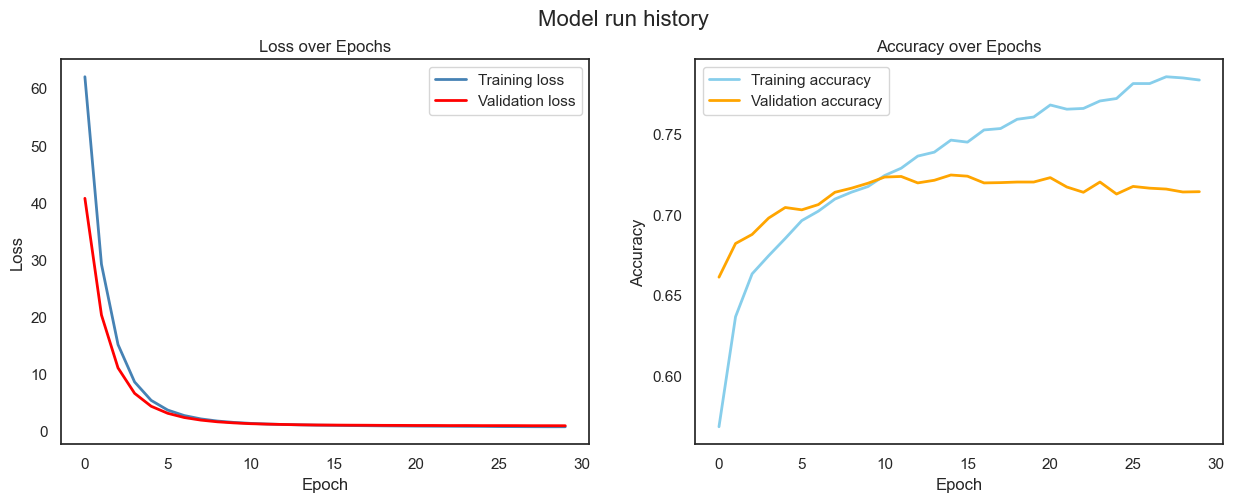

In [26]:
#Fit the model (30 training epochs) 
RNN_run_history = RNN_model.fit(X_train, y_train, 
                                epochs=30,
                                batch_size=16,
                                validation_data=(X_val, y_val),
                                callbacks=[lr_scheduler, early_stop])

#Visualize run history
plot_training_history([RNN_run_history], metrics=['loss', 'accuracy'])


**Model Evaluation**

In [27]:
#Evaluate the model on the testing set
loss, accuracy = RNN_model.evaluate(X_test, y_test, verbose=0)

#Get class predictions
y_pred = RNN_model.predict(X_test, verbose=0).argmax(axis=-1)

#Report results
print('Model Evaluation Results:\n')
error_scores(y_test, y_pred, accuracy, classes=classes)


Model Evaluation Results:



,neutral,positive,negative
Accuracy,0.72,0.72,0.72
Precision,0.68,0.77,0.71
Recall,0.72,0.74,0.69
F1 score,0.70,0.76,0.70


As illustrated, the model training and performance on testing were satisfactory. Indeed, accuracy improved significantly from the baseline, increasing by 75%, with overall accuracy score of 0.72 (compared to 0.40 at baseline). Further, more importantly, the model successfully learned to differentiate positive and negative sentiments from each other and from neutral ones. We can see this more strikingly with the recall and F1 scores. Whereas the recall and F1 scores hardly went above 0.1 at baseline for positive and negative sentiments, with the current network they shot up to ~0.7-0.75. This indeed shows that the network learned appropriate embeddings, carving up a satisfactory representations space for the words and their semantic relationships and dependencies. This makes perfect sense of course as these types of networks are specialized for such a type of task, using a specialized embedding layer for word representation, sentiment emphasis and self-attention layers for identifying emotional terms and relevant terms overall, as well as convolutional layers for local pattern and feature extraction and a LSTM layer for context awareness and learning temporal/semantic dependencies. None of these capabilities are available for the simple logistic regression model, hence the stark difference in performance. Now we can use the model to generate sentiment predictions on a random sample of data from the testing set.

**Generating Sentiment Predictions from a Random Sample**

In [33]:
#Extracting a random sample from the dataset
random_indices = tf.constant(np.random.choice(len(X_test), size=10, replace=False), dtype=tf.int32)
X_sample = tf.gather(X_test, random_indices)

#Generate sentiment predictions using the model
predicted_sentiment = RNN_model.predict(X_sample).argmax(axis=-1)

#Decode tokens of selected sample 
X_sample_raw = [decode_tokens(row, idx2word) for row in X_sample.numpy()]

#Create a dataframe
X_sample_df = pd.DataFrame({'Tweet (preprocessed)': X_sample_raw, 
                            'Predicted Sentiment': predicted_sentiment})

X_sample_df['Predicted Sentiment'] = X_sample_df['Predicted Sentiment'].map({0: 'neutral', 1: 'positive', 2: 'negative'})

#Display results 
X_sample_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


,Tweet (preprocessed),Predicted Sentiment
0,going bed good night everyone love say good morning sweet dream,positive
1,haha best thing office birthday hey,positive
2,sanjaya forever hahahahahaha,neutral
3,kel17 ehh carnt stand hot weather,negative
4,quick answer put bleach wash start middle dont laugh,neutral
5,lol girl video disturbed love hk theme cute,positive
6,nobody home tonight except alone sigh oh wish,negative
7,fun though,positive
8,repeat final second game 3 dalden please official anyway happy mother day,positive
9,hello hows life side screen,neutral


### Summary <br>

In summary, this project set out to perform sentiment analysis on Twitter data using deep learning and NLP techniques. An advanced recurrent neural network was developed for the task, incorporating sophisticated sentiment detection and attentional capabilities, and used to classify tweets into positive, neutral, or negative. As demonstrated by the training history and evaluation metrics, the model achieved a relatively strong performance, with good accuracy and generalization to the test set. The network was also tested on individual tweets, providing real-time sentiment classification capability, and was able to make generally reasonable and consistent sentiment predictions across a variety of tweets, indicating that it effectively learned from the training data. Thus, the project successfully leveraged deep learning to develop a functional sentiment analysis model capable of classifying tweet sentiments with considerable accuracy.